In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
import pickle
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../../src')

In [5]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_melanoma.h5ad')
adata

AnnData object with n_obs × n_vars = 4804 × 3392
    obs: 'X', 'Y', 'cell_type', 'author_cell_type', 'cell_type_int'
    uns: 'author_cell_type_colors', 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [62]:
import json

with open('./colors.json', 'r') as f:
    color_dict = json.load(f)
    
figure_params = {
    'dpi': 300, 
    'bbox_inches': 'tight', 
    'format': 'svg', 
    'transparent': True
}

In [6]:
# tumor_mask = adata.obs['cell_type'] == 'Tumor 1'
# fig, ax = plt.subplots(figsize=(10,8))
# x = adata.obsm['spatial'][tumor_mask,0]
# y = adata.obsm['spatial'][tumor_mask,1]

# ax.scatter(adata.obsm['spatial'][~tumor_mask,0], 
#     adata.obsm['spatial'][~tumor_mask,1], alpha=1, color='lightgrey', s=20, 
#     linewidth=0.5, edgecolor='black')

# ax.scatter(adata.obsm['spatial'][tumor_mask,0], 
#     adata.obsm['spatial'][tumor_mask,1], alpha=1, 
#     color='red', s=20, linewidth=0.5, edgecolor='black')

# sns.kdeplot(x=x, y=y, cmap='magma', fill=False, ax=ax, levels=7, thresh=0.4)


# ax.axis('equal')
# ax.set_frame_on(False)
# ax.set_xticks([])
# ax.set_yticks([])

# ax.set_title('Tumor cell density and locations')
# plt.show()

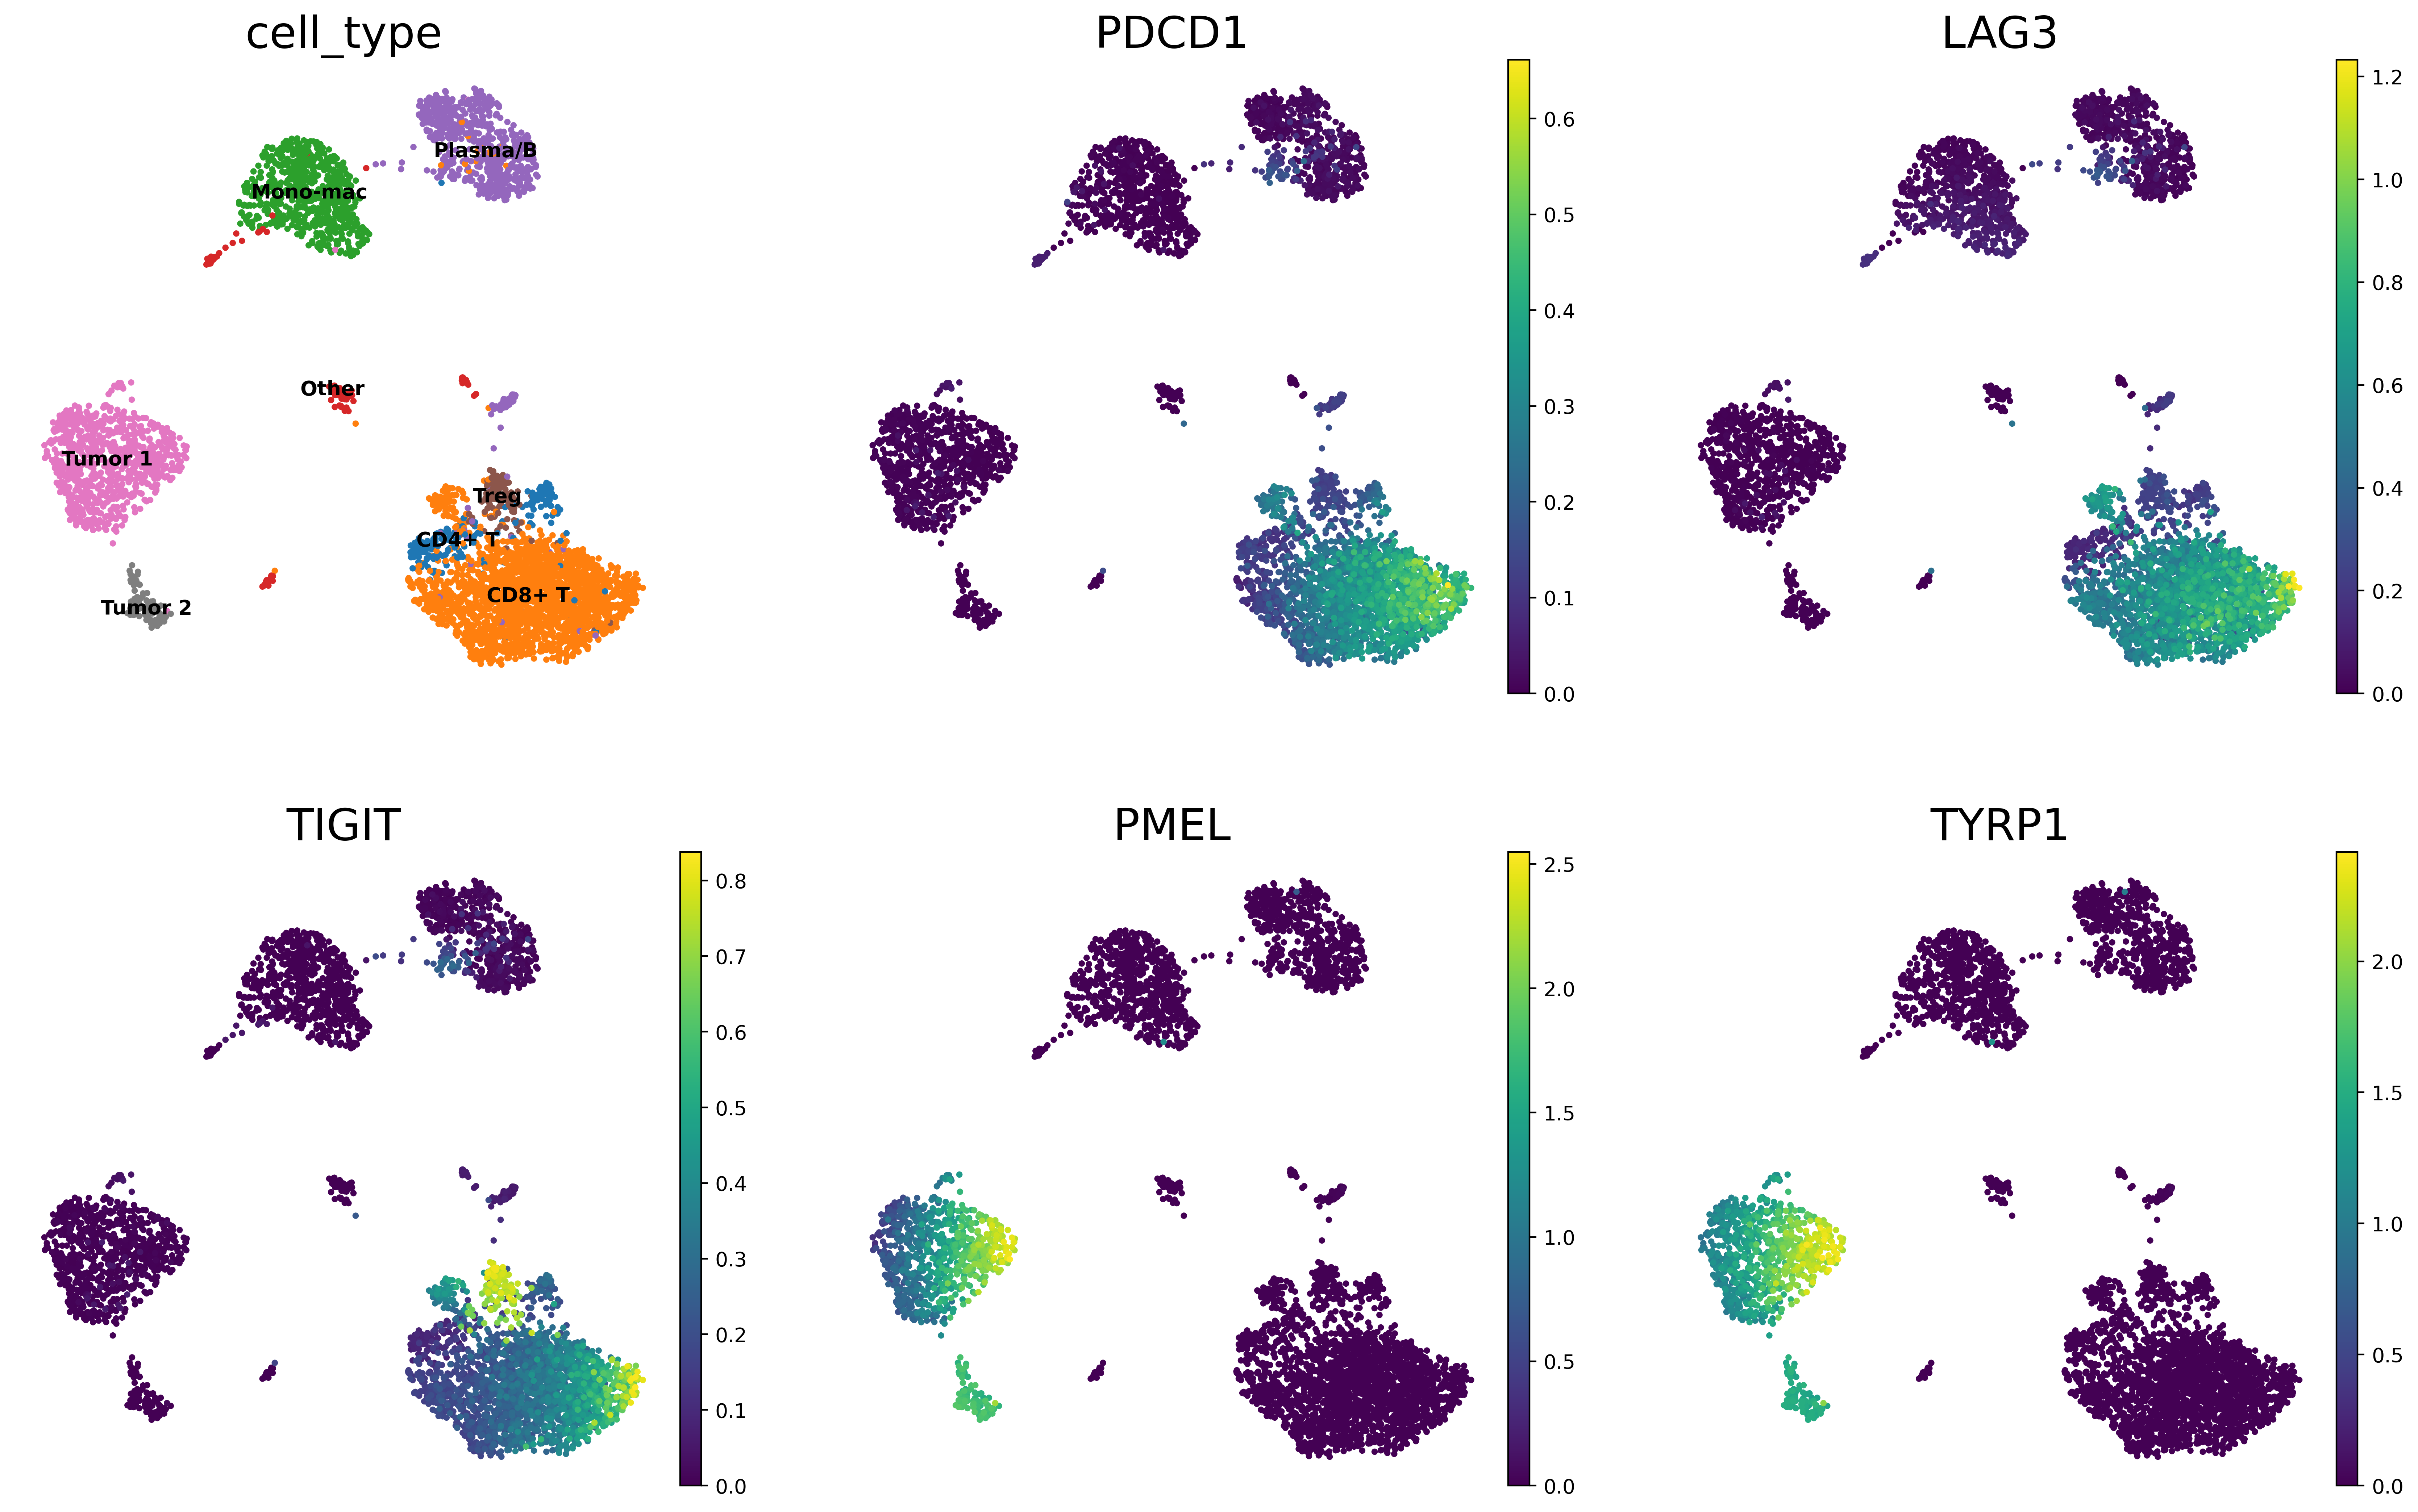

In [7]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 200
markers = ['cell_type', 'PDCD1', 'LAG3','TIGIT', 'PMEL', 'TYRP1']
ax = sc.pl.umap(adata, color=markers, legend_loc='on data', 
    layer='imputed_count', s=40, frameon=False, 
    ncols=3, show=False, add_outline=False)

for ax in plt.gcf().axes:
    ax.set_title(ax.get_title(), size=22)

plt.savefig(
    './figures/markers.svg',
    **figure_params)
plt.show()

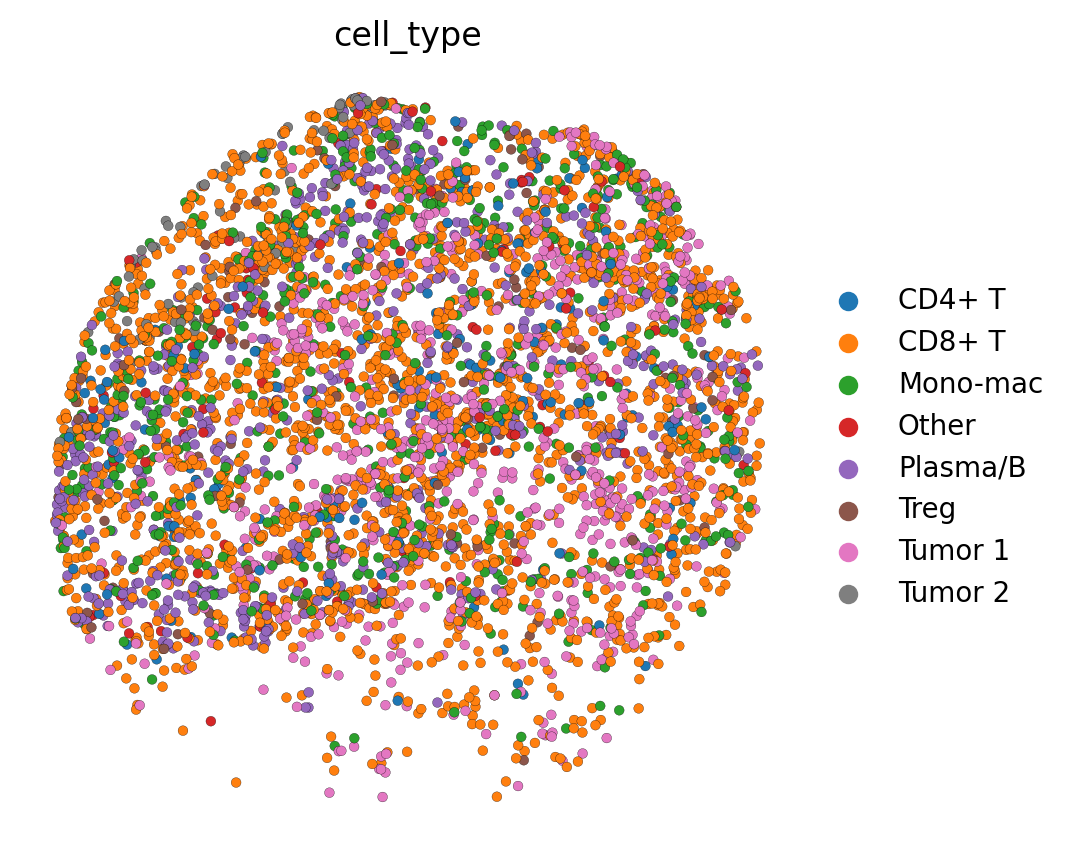

In [110]:
sc.pl.embedding(adata, color='cell_type', s=50, 
    frameon=False, ncols=3, show=False, basis='spatial', 
    linewidth=0.1, edgecolor='black')
plt.savefig(
    './figures/melanoma_spatial.svg',
    **figure_params)
plt.show()

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
with open('../../notebooks/melanoma_slidetags/interactions.pkl', 'rb') as f:
    interactions = pickle.load(f)

In [15]:
interactions['CD8+ T']

interaction       gene          beta interaction_type
CD8+ T                                                            
0                  beta0        A2M  1.023275e+00               tf
1                  beta0        ADA  5.175636e-02               tf
2                  beta0     ADAM19  2.944441e-01               tf
3                  beta0     ADAM28  7.644998e-03               tf
4                  beta0     ADAM29  1.459620e-02               tf
...                  ...        ...           ...              ...
88606      beta_IGF1#VDR      TGFB1 -1.123710e-03        ligand-tf
88607   beta_IL26#ZNF331      TGFB3 -4.041979e-04        ligand-tf
88608     beta_IL22#TP63  TNFRSF10A -5.010410e-05        ligand-tf
88609    beta_BMP7#GATA3     TNFSF4  1.912510e-05        ligand-tf
88610    beta_OSTN#NR2F1      VEGFA -9.906613e-07        ligand-tf

[979503 rows x 4 columns]

In [10]:
dfr = interactions['Tumor 1'].query('gene.str.contains("PMEL") and interaction_type=="ligand-receptor"').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)

mean_cd8_expr = adata.to_df(layer='imputed_count')[
    adata.obs.cell_type=='CD8+ T'].mean().to_frame().loc[
        dfr.index.str.replace('beta_', '').str.split('$').str[0].values]

mean_tumor_expr = adata.to_df(layer='imputed_count')[
    adata.obs.cell_type=='Tumor 1'].mean().to_frame().loc[
        dfr.index.str.replace('beta_', '').str.split('$').str[1].values]
    
dfr['mean_cd8_expr'] = mean_cd8_expr.values
dfr['mean_tumor_expr'] = mean_tumor_expr.values
# dfr['weighted_beta'] = dfr['beta'] * dfr['mean_cd8_expr'] * dfr['mean_tumor_expr']
dfr['weighted_beta'] = dfr['beta'] * dfr['mean_cd8_expr']
dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')
top_interactions = dfr[dfr['weighted_beta'] < 0].sort_values(by='weighted_beta', ascending=True).head(15)[::-1]

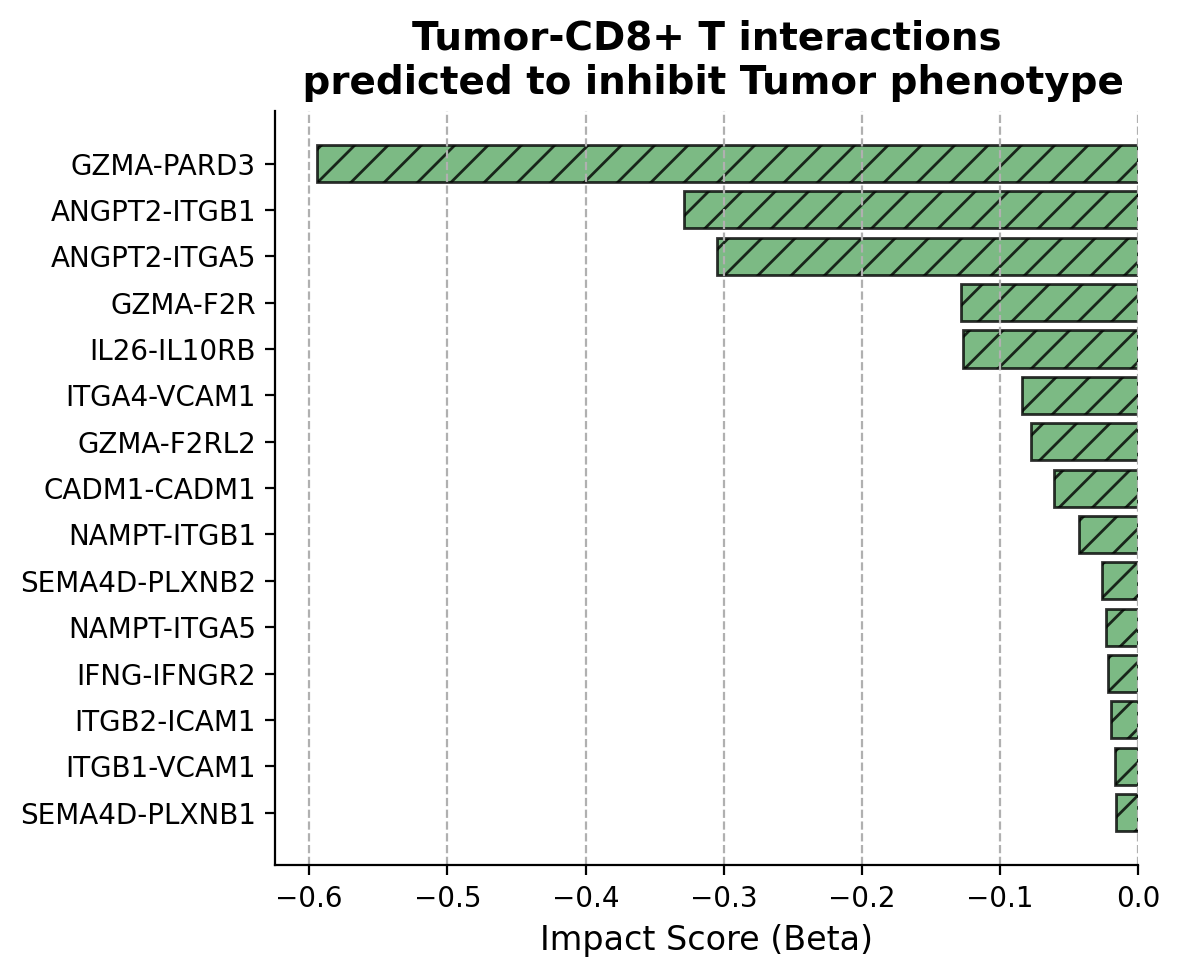

In [159]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
bars = ax.barh(top_interactions.index, top_interactions['weighted_beta'], 
    color='#5ba966', edgecolor='black', alpha=0.8, hatch='//')
ylabels = [label.get_text() for label in ax.get_yticklabels()]

ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Tumor-CD8+ T interactions\n predicted to inhibit Tumor phenotype', 
            fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(
    './figures/melanoma_interactions.svg',
    **figure_params)
plt.show()

In [11]:
from pycirclize import Circos
import pandas as pd

In [24]:
dfr = interactions['Tumor 1'].query('gene.str.contains("PMEL") and interaction_type=="ligand-receptor"').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)

mean_cd8_expr = adata.to_df(layer='imputed_count')[
    adata.obs.cell_type=='CD8+ T'].mean().to_frame().loc[
        dfr.index.str.replace('beta_', '').str.split('$').str[0].values]

mean_tumor_expr = adata.to_df(layer='imputed_count')[
    adata.obs.cell_type=='Tumor 1'].mean().to_frame().loc[
        dfr.index.str.replace('beta_', '').str.split('$').str[1].values]
    
dfr['mean_cd8_expr'] = mean_cd8_expr.values
dfr['mean_tumor_expr'] = mean_tumor_expr.values
dfr['weighted_beta'] = dfr['beta'] * dfr['mean_cd8_expr'] * dfr['mean_tumor_expr']
# dfr['weighted_beta'] = dfr['beta'] * dfr['mean_cd8_expr']
dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')
dfr[dfr['weighted_beta'] < 0].sort_values(by='weighted_beta', ascending=True).head(15)

gene      beta interaction_type  mean_cd8_expr  \
interaction                                                     
GZMA-PARD3     PMEL -0.542300  ligand-receptor       1.096606   
ANGPT2-ITGB1   PMEL -0.576036  ligand-receptor       0.570179   
CADM1-CADM1    PMEL -0.328405  ligand-receptor       0.185705   
ANGPT2-ITGA5   PMEL -0.535006  ligand-receptor       0.570179   
GZMA-F2R       PMEL -0.117220  ligand-receptor       1.096606   
IL26-IL10RB    PMEL -0.426983  ligand-receptor       0.297919   
IFNG-IFNGR2    PMEL -0.152065  ligand-receptor       0.144629   
ITGB2-ICAM1    PMEL -0.053165  ligand-receptor       0.375108   
NAMPT-ITGB1    PMEL -0.810325  ligand-receptor       0.052629   
SEMA4D-PLXNB2  PMEL -0.017121  ligand-receptor       1.523490   
ITGA4-VCAM1    PMEL -0.047974  ligand-receptor       1.754226   
LAMB1-CD44     PMEL -0.053029  ligand-receptor       0.041497   
COL6A6-CD44    PMEL -0.062789  ligand-receptor       0.032644   
TGFB1-TGFBR1   PMEL -0.068532  ligand-receptor       0.236111   
LAMB1-ITGB8    PMEL -0.062572  ligand-receptor       0.041497   

               mean_tumor_expr  weighted_beta  
interaction                                    
GZMA-PARD3            1.295530      -0.770438  
ANGPT2-ITGB1          0.278722      -0.091544  
CADM1-CADM1           1.023928      -0.062446  
ANGPT2-ITGA5          0.086490      -0.026384  
GZMA-F2R              0.132073      -0.016977  
IL26-IL10RB           0.131490      -0.016726  
IFNG-IFNGR2           0.715155      -0.015728  
ITGB2-ICAM1           0.668421      -0.013330  
NAMPT-ITGB1           0.278722      -0.011886  
SEMA4D-PLXNB2         0.427684      -0.011156  
ITGA4-VCAM1           0.125406      -0.010554  
LAMB1-CD44            1.883179      -0.004144  
COL6A6-CD44           1.883179      -0.003860  
TGFB1-TGFBR1          0.229555      -0.003714  
LAMB1-ITGB8           1.362787      -0.003539

In [26]:
row_names = ['Plasma/B','CD8+ T', 'CD4+ T', 'Treg', 'Treg']
col_names = ['Tumor 1', 'Tumor 2']
matrix_data = [
    [83, 79],
    [90, 118],
    [165, 81],
    [121, 77],
    [187, 197],
    # [177, 8],
    # [141, 127],
    # [29, 27],
    # [95, 82],
    # [107, 39],
]
matrix_df = pd.DataFrame(matrix_data, index=row_names, columns=col_names)
matrix_df

Tumor 1  Tumor 2
Plasma/B       83       79
CD8+ T         90      118
CD4+ T        165       81
Treg          121       77
Treg          187      197

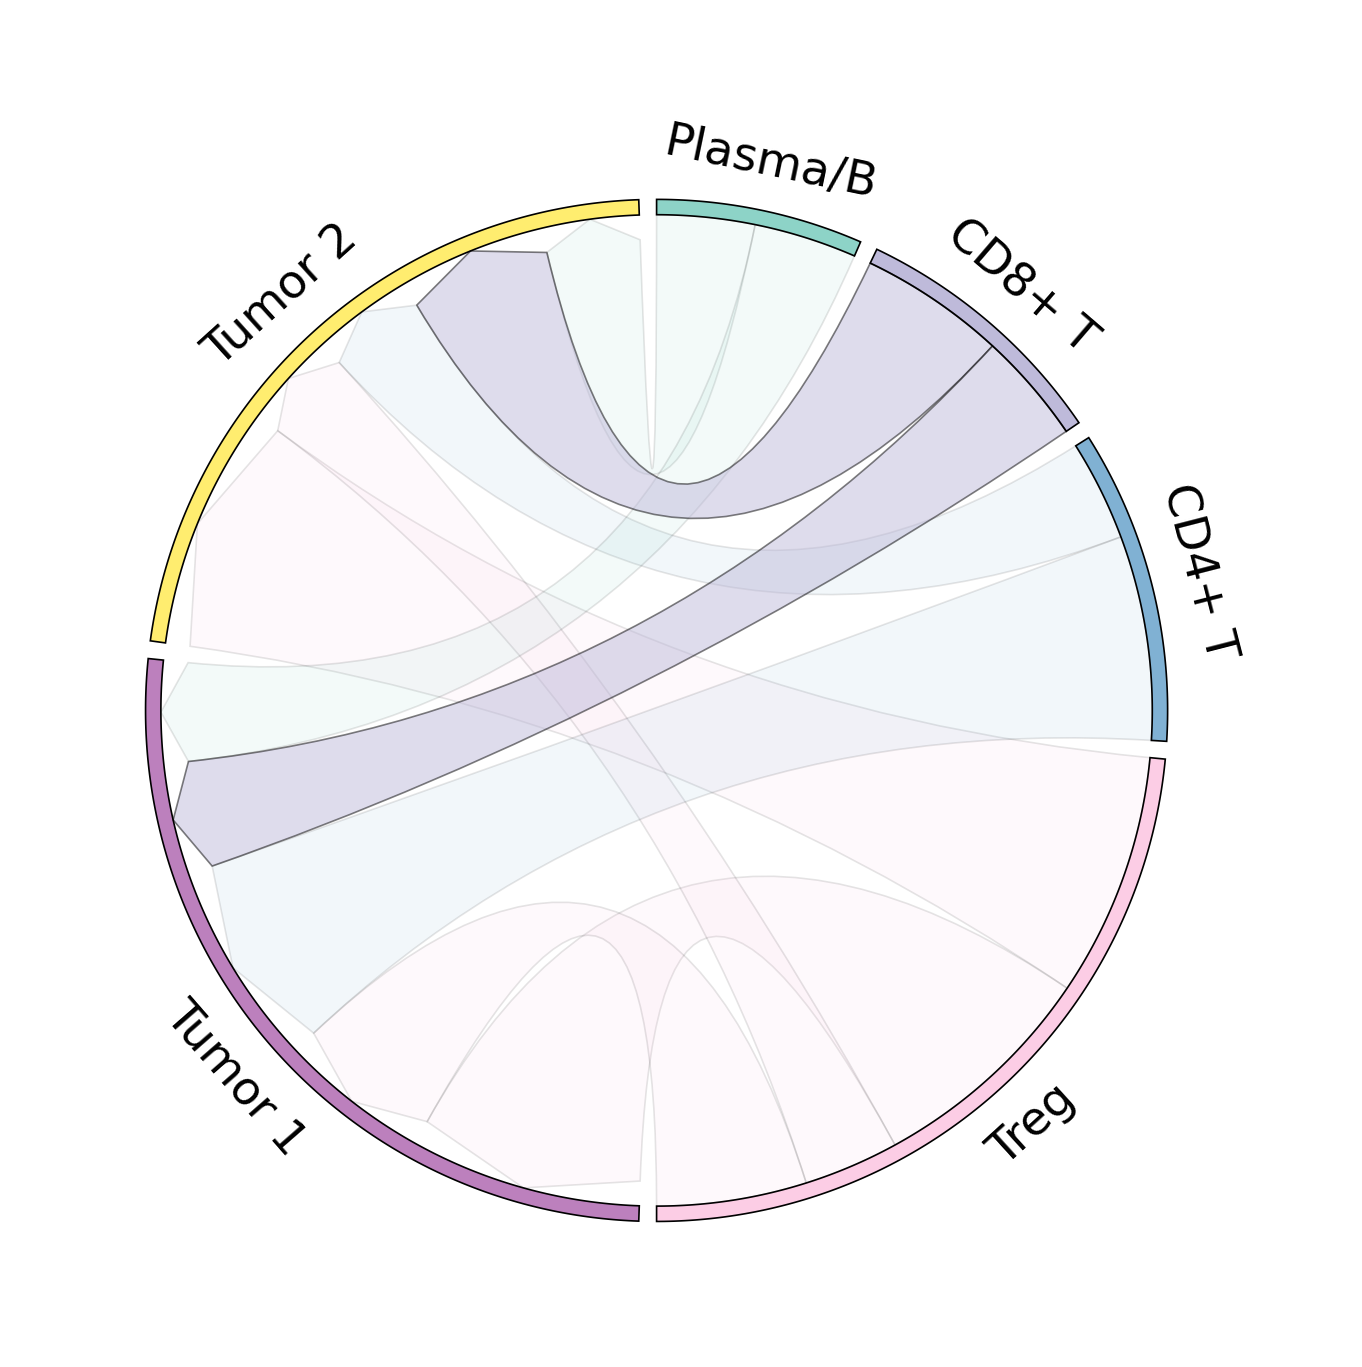

In [29]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 100


def link_kws_handler(from_label: str, to_label: str):
    if from_label in ('CD8+ T'):
        return dict(alpha=0.5, zorder=1.0)
    else:
        return dict(alpha=0.1, zorder=0)

circos = Circos.chord_diagram(
    matrix_df,
    space=2,
    cmap="Set3",
    label_kws=dict(size=14),
    link_kws=dict(direction=1, ec="black", lw=0.5),
    link_kws_handler=link_kws_handler,
)

fig = circos.plotfig(figsize=(5, 5), dpi=120)

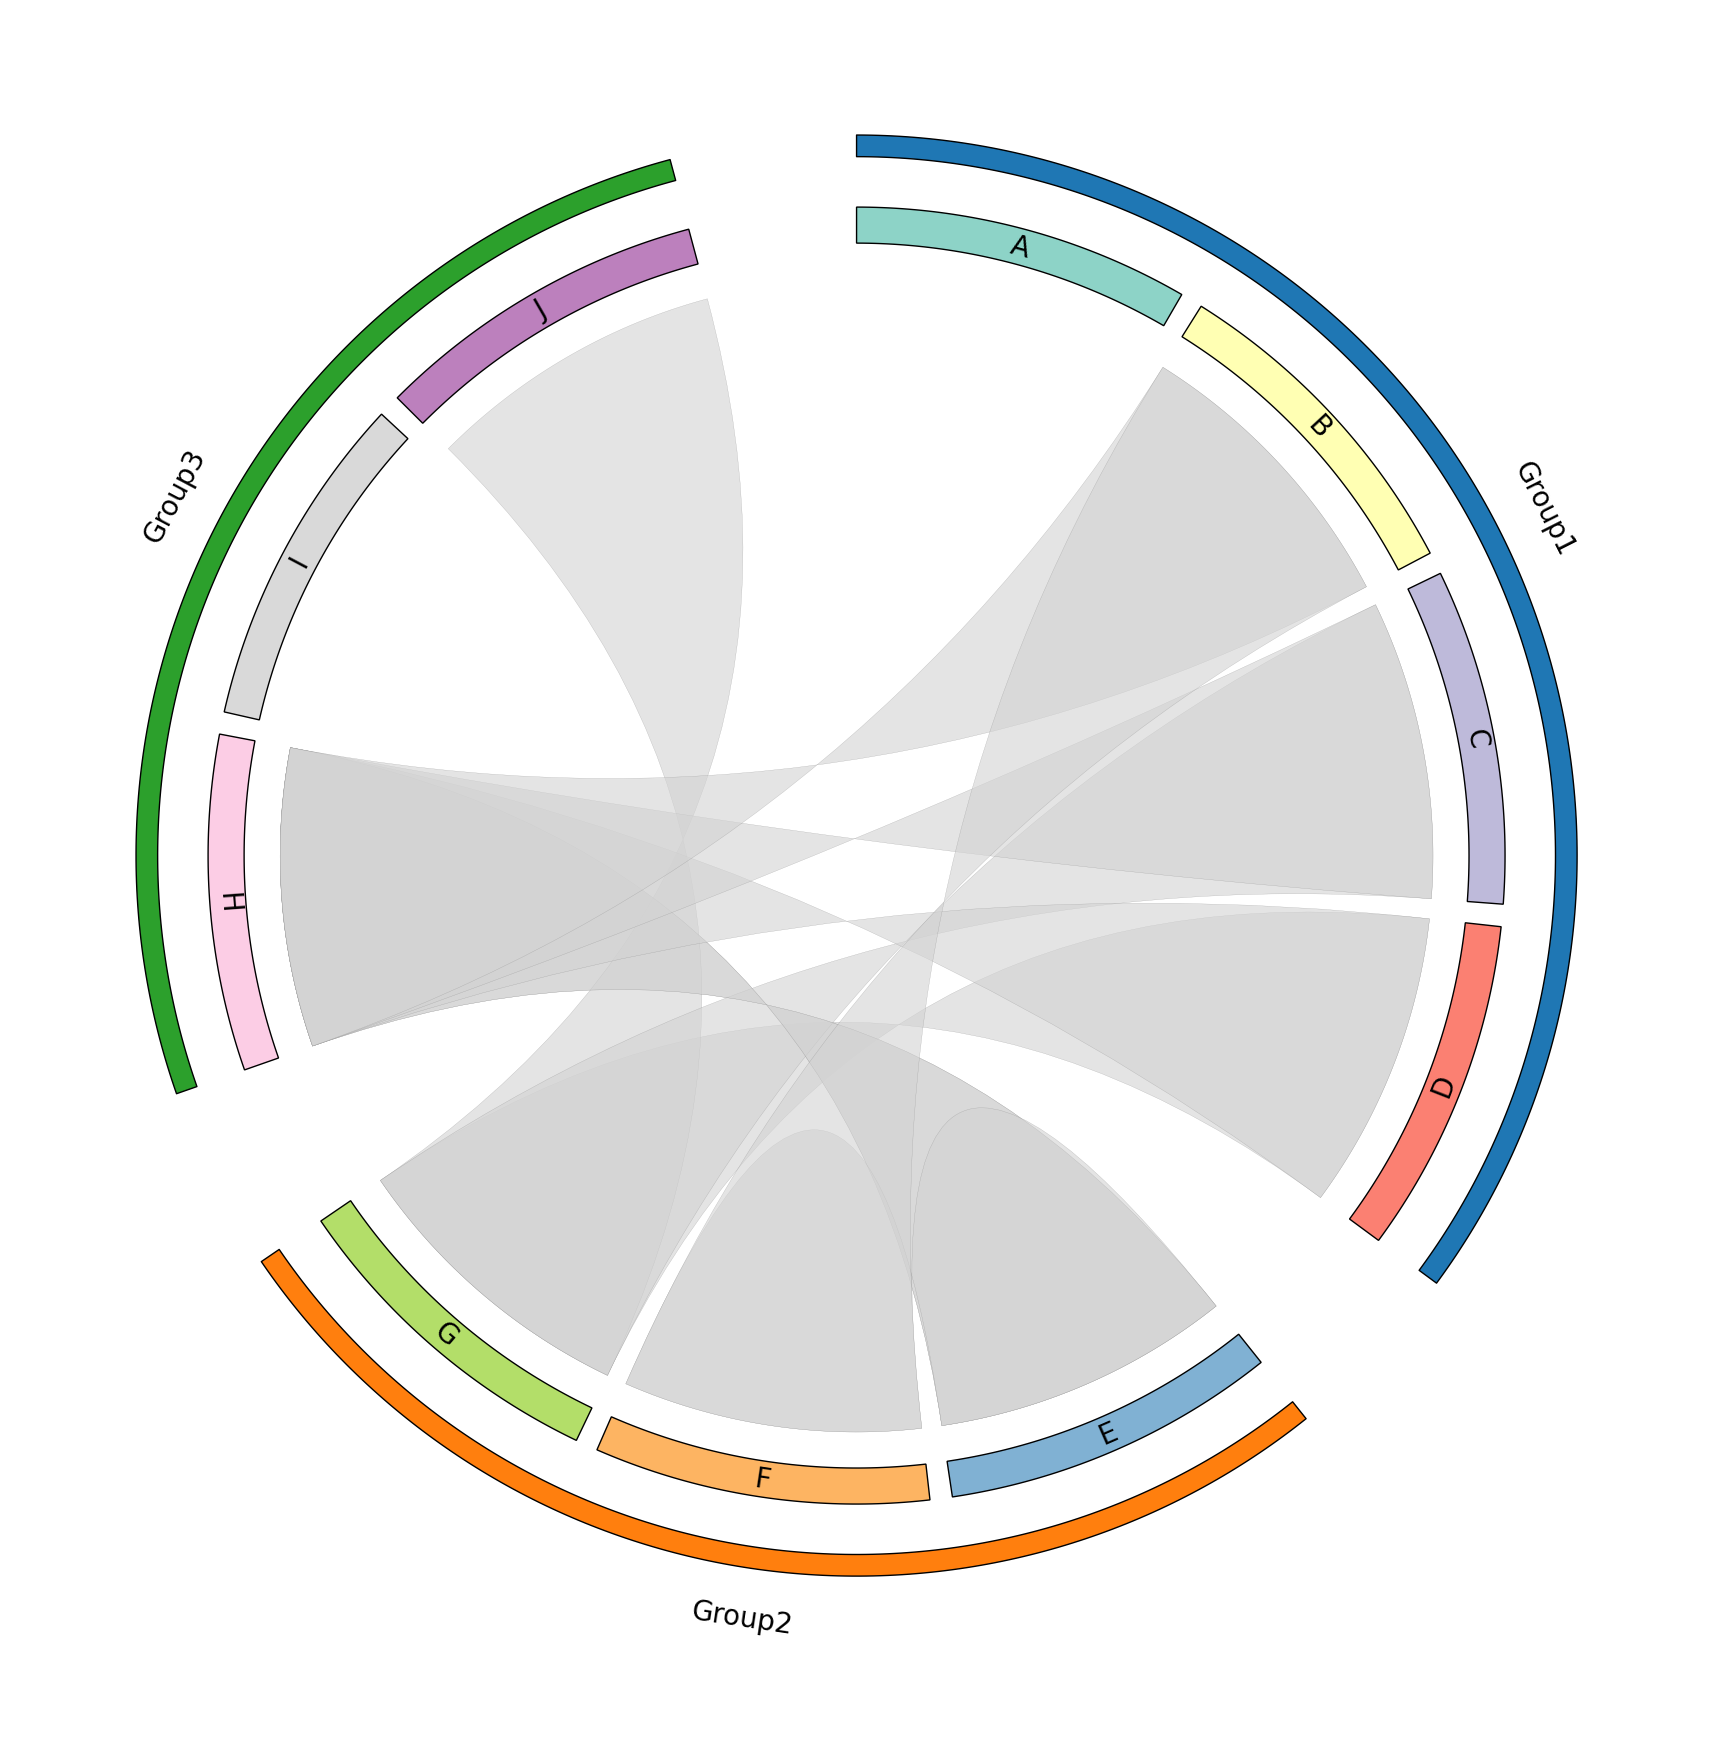

In [40]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler
import numpy as np

sectors = {name: 10 for name in "ABCDEFGHIJ"}
group1, group2, group3 = list("ABCD"), list("EFG"), list("HIJ")

spaces = calc_group_spaces([4, 3, 3], space_bw_group=15, space_in_group=2)
circos = Circos(sectors, space=spaces)

ColorCycler.set_cmap("Set3")
for sector in circos.sectors:
    track = sector.add_track(r_lim=(85, 90))
    track.axis(fc=ColorCycler())
    track.text(sector.name)

ColorCycler.set_cmap("tab10")
for idx, group in enumerate((group1, group2, group3), 1):
    group_deg_lim = circos.get_group_sectors_deg_lim(group)
    circos.rect(r_lim=(97, 100), deg_lim=group_deg_lim, fc=ColorCycler(), ec="black", lw=0.5)
    group_center_deg = sum(group_deg_lim) / 2
    circos.text(f"Group{idx}", r=105, deg=group_center_deg, adjust_rotation=True)

# Add random links between sectors
np.random.seed(42)
for _ in range(10):
    from_sector = np.random.choice(circos.sectors)
    to_sector = np.random.choice(circos.sectors)
    if from_sector != to_sector:
        circos.link(
            (to_sector.name, 0, 10),
            (from_sector.name, 0, 10),
            r1=80,
            r2=80,
            fc="lightgray", 
            alpha=0.6
        )

fig = circos.plotfig()

In [43]:
from spaceoracle.virtual_tissue import VirtualTissue

In [44]:
melanoma = VirtualTissue(
    adata = adata,
    annot = 'cell_type',
    color_dict=color_dict,
    spf_radius=200
)

In [41]:
perturbed_df = pd.read_parquet(f'/Volumes/SSD/genome_screens/melanoma_special/PATZ1_CD8T_KO.parquet')

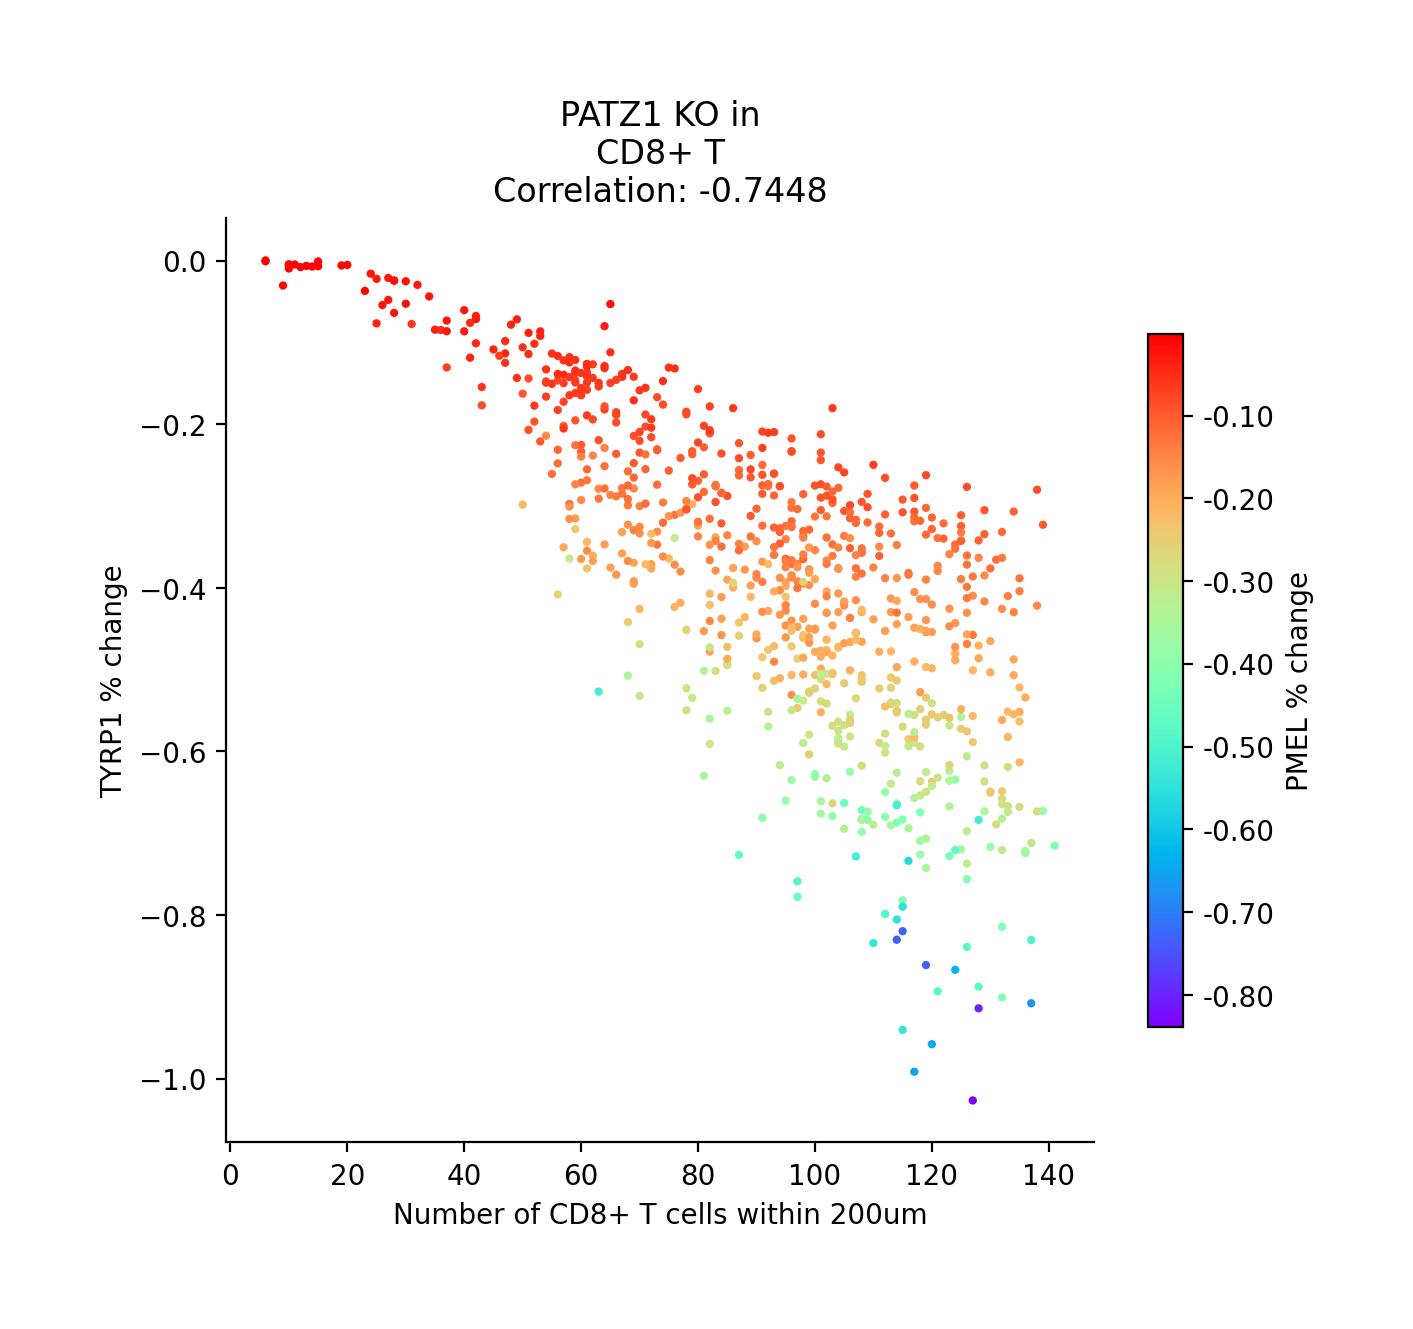

In [63]:
plt.rcParams['figure.figsize'] = (7, 6)
plt.rcParams['figure.dpi'] = 100

ax, _ = melanoma.plot_gene_vs_proximity(
    perturb_target='PATZ1', 
    perturbed_df=perturbed_df, 
    gene='TYRP1', 
    gene_threshold=-1,
    color_gene='PMEL', 
    cell_filter='Tumor 1', 
    cell_groups=['CD8+ T']
)

## fix title bug when KO are only in one celltype
ax.set_title(ax.get_title().replace('Tumor 1', 'CD8+ T'))
plt.savefig(
    './figures/melanoma_proximity_CD8.svg',
    **figure_params)
plt.show()

In [132]:
melanoma.init_cartography(adata)

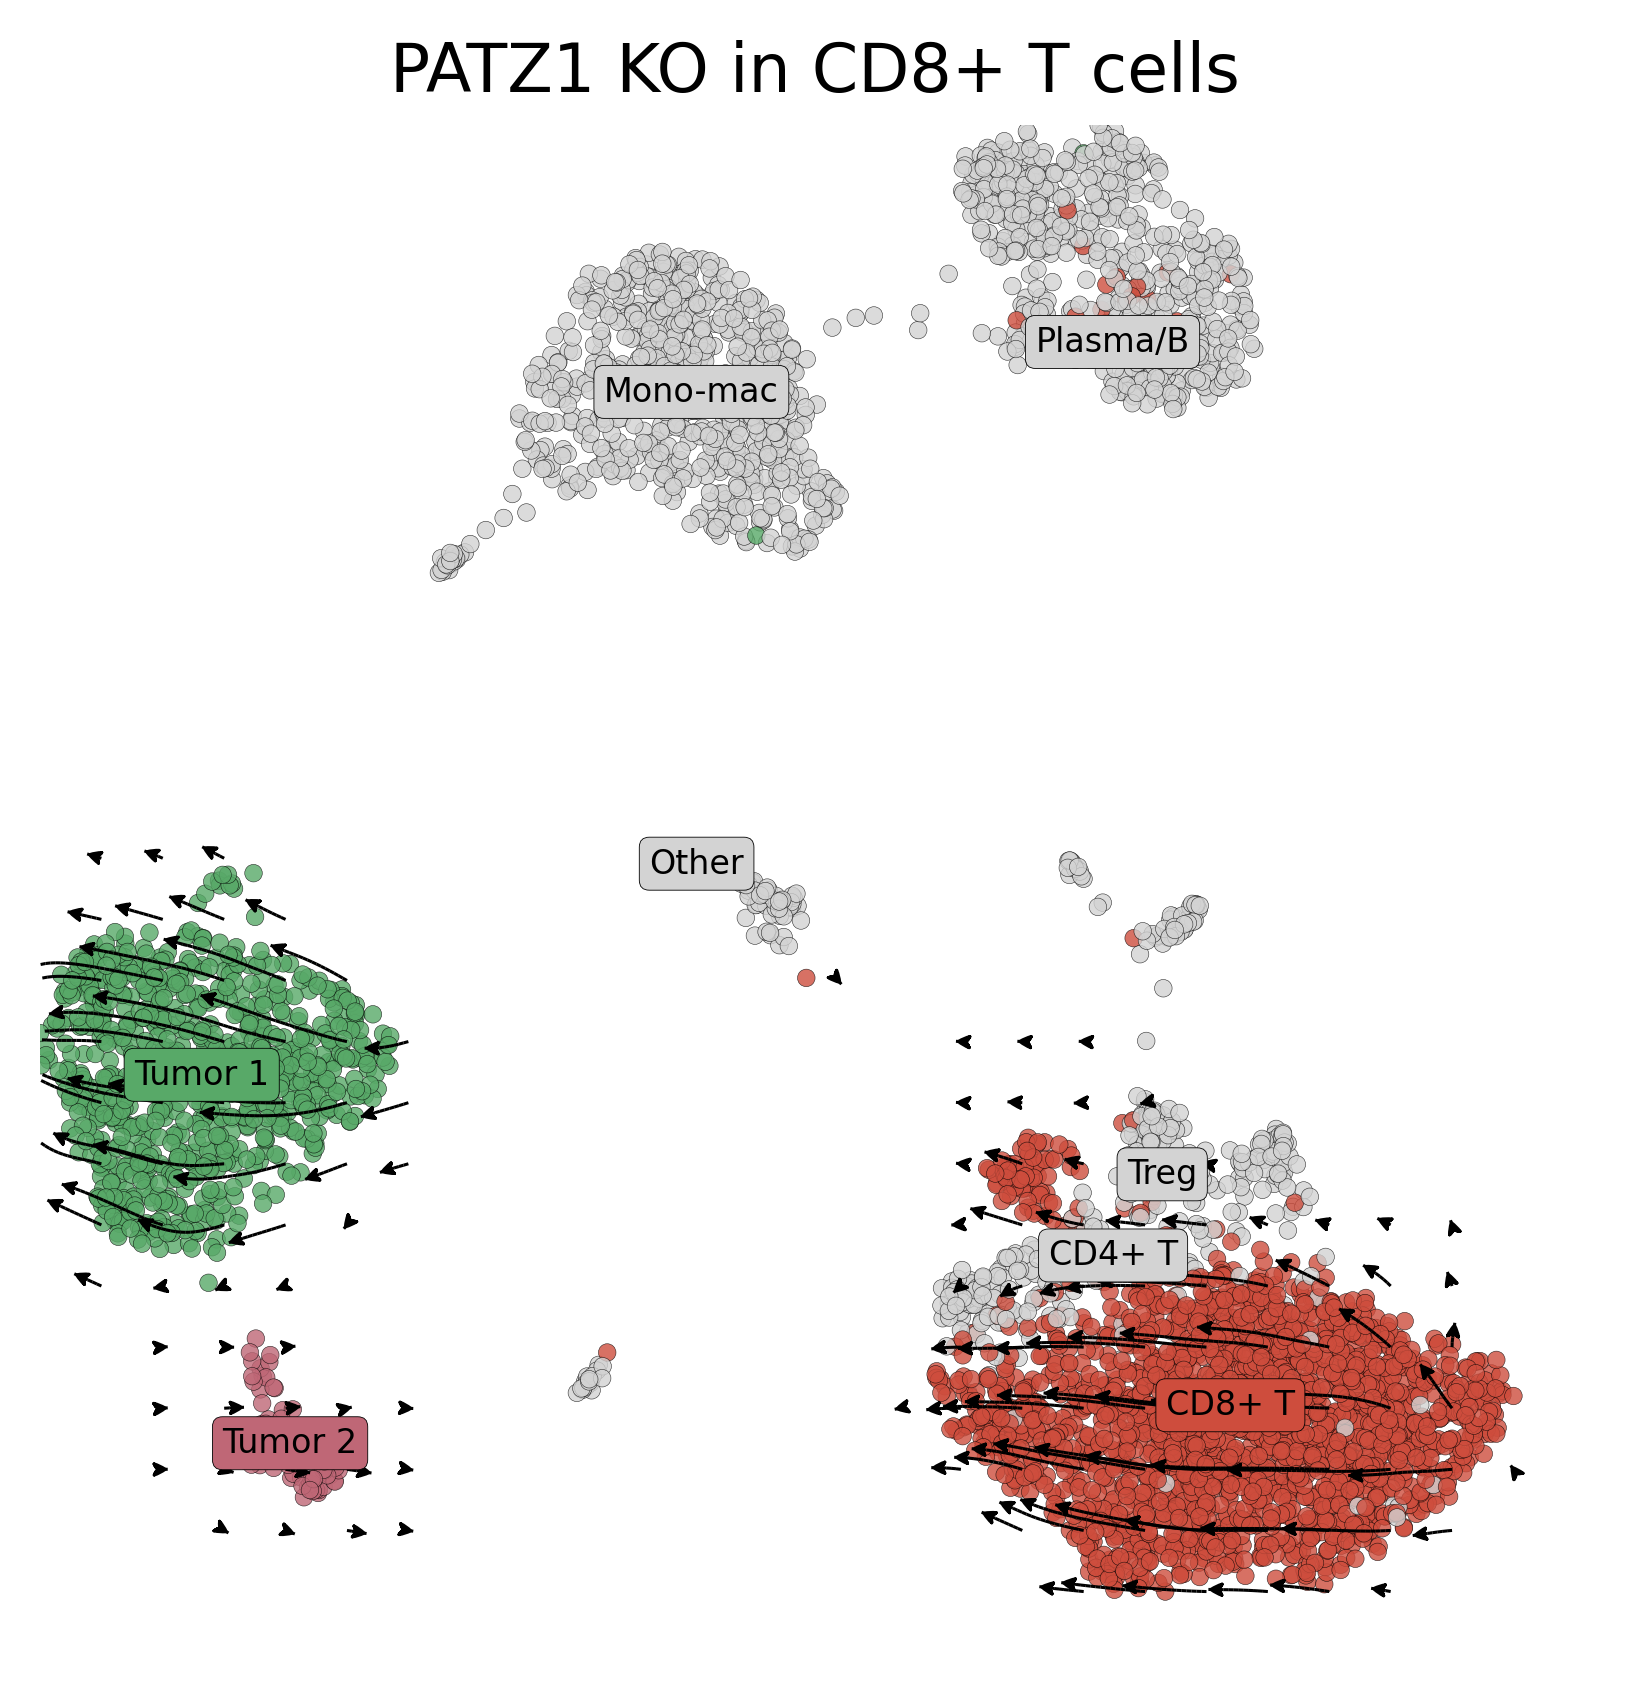

In [135]:
melanoma.plot_arrows(
    perturb_target='', 
    perturbed_df=perturbed_df,
    mode='0',
    hue='cell_type',
    curve=True,
    vector_scale=0.4, 
    grid_scale=1,
    n_neighbors=100,
    scale=4, 
    grains=25,
    figsize=(5, 5),
    dpi=200,
    scatter_size=10,
    legend_fontsize=6,
    limit_clusters=True,
    highlight_clusters=[
        'Tumor 1', 
        'Tumor 2',
        'CD8+ T'
    ]
)
plt.title('PATZ1 KO in CD8+ T cells')
plt.savefig(
    './figures/PATZ1_KO.svg',
    **figure_params)
plt.show()